**Prophet Model without regressors**

**Contains parameters that are modified to suit the data and takes 7 days data to forecast 1 day** 

**Training Phase**

21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing


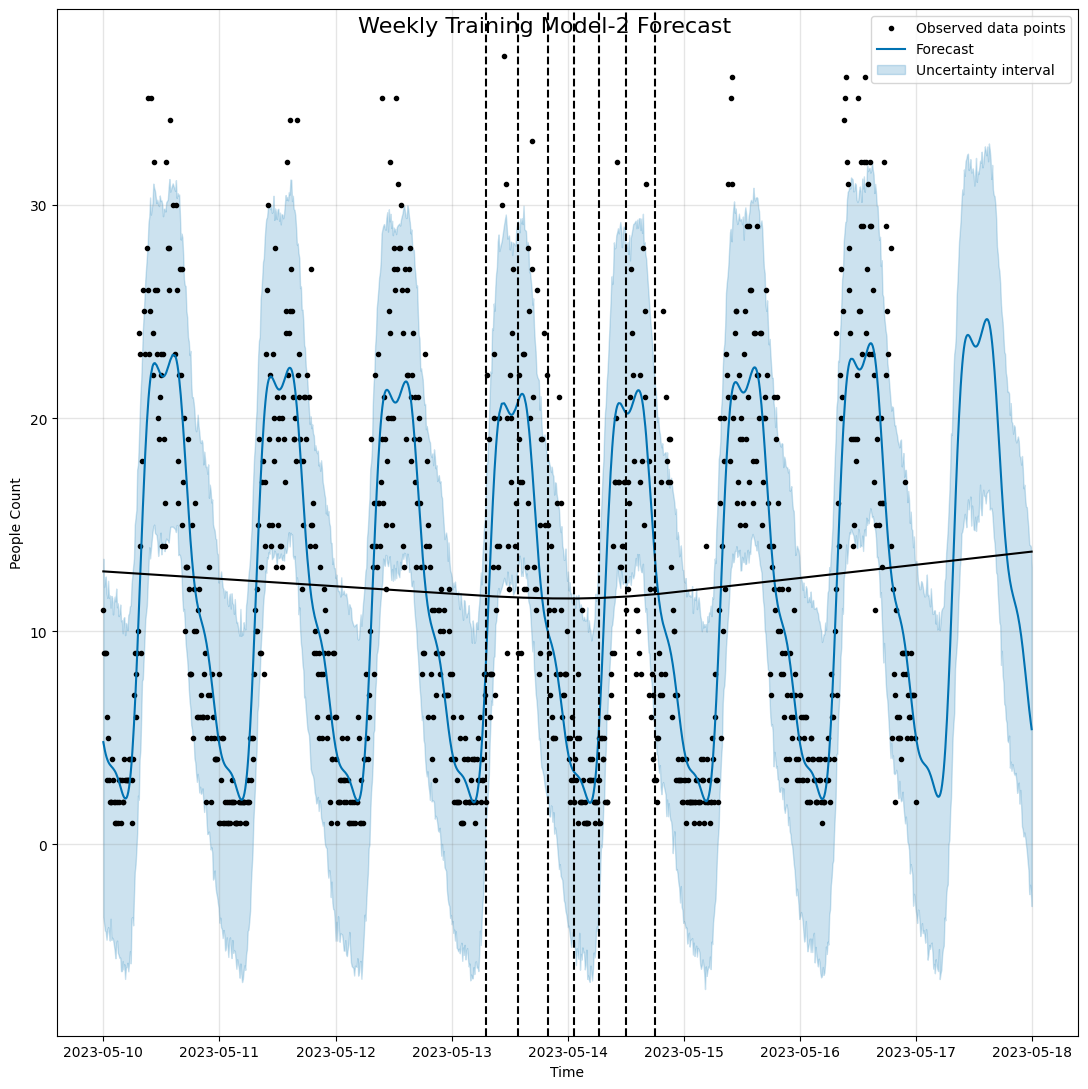

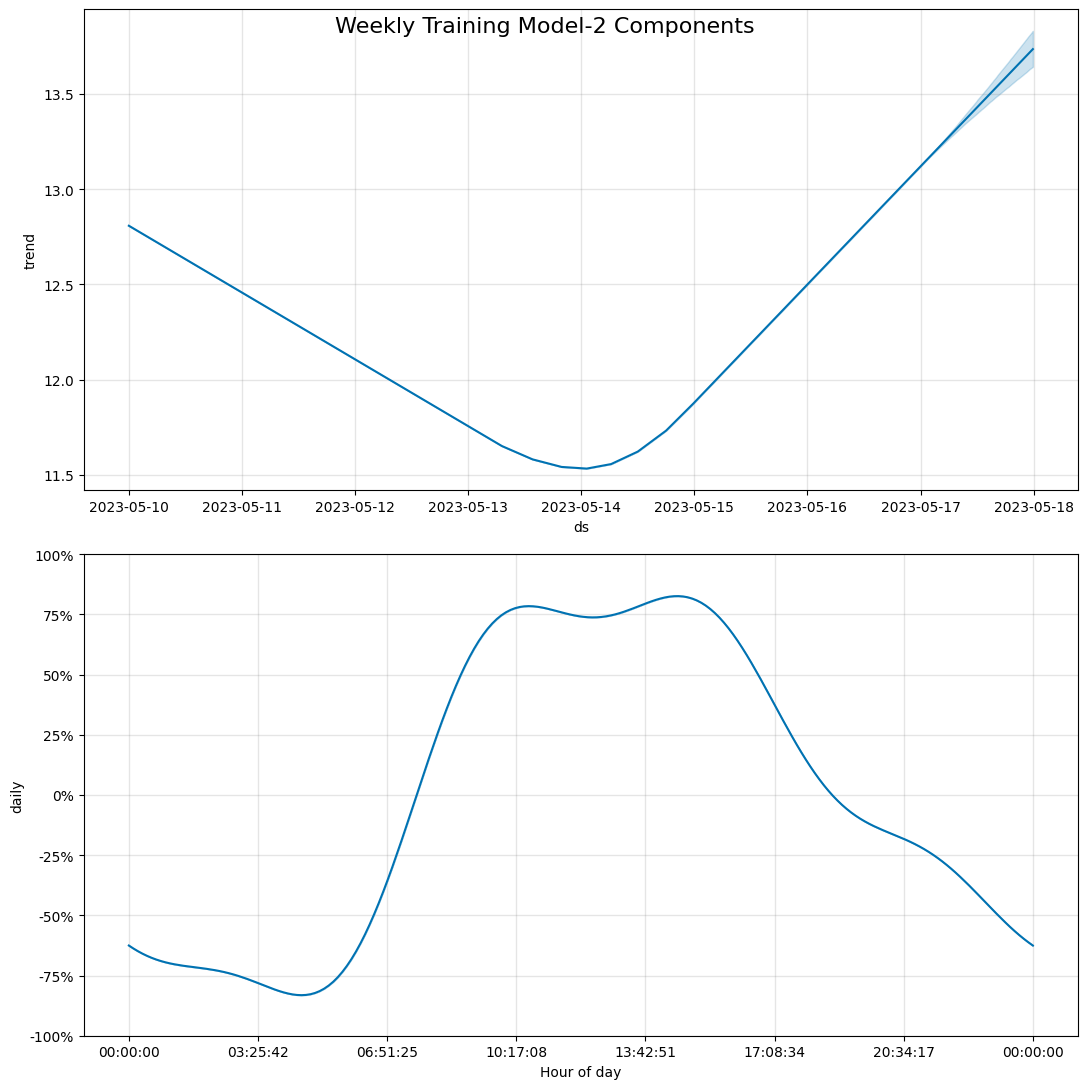

In [9]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from meteostat import Hourly
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Choose the start date and end date for the one-week subset
start_date = '2023-05-10 00:00:00'
end_date = '2023-05-16 23:59:59'

# Filter the DataFrame to include only the data for the selected week
selected_week_data = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
# Reset the index and drop the old index (unnamed column)
selected_week_data = selected_week_data.reset_index(drop=True).drop(columns=['Unnamed: 0'])


start = datetime.strptime(start_date,'%Y-%m-%d %H:%M:%S')
end = datetime.strptime(end_date,'%Y-%m-%d %H:%M:%S')

#--------------------------------------------------------------------------------------------#
#Importing weather data from MeteoStat

def fetch_weather_data(location_id, start_date, end_date):
    """
    Fetch weather data for a given location, start date, and end date.

    Parameters:
    - location_id: The location ID for the desired location.
    - start_date: The start date for fetching weather data.
    - end_date: The end date for fetching weather data.

    Returns:
    - DataFrame containing weather data.
    """

    # Fetch weather data using meteostat library
    data = Hourly(location_id, start_date, end_date)
    weather_data = data.fetch().reset_index()
    weather_data = weather_data[['time', 'temp', 'coco']]

    return weather_data


# Fetch weather data
weather_data = fetch_weather_data(10675,start,end)


#Get future predictions add 1 second and 24hr to end time
prediction_start_date = pd.to_datetime(end_date) + pd.DateOffset(seconds=1)
prediction_end_date = pd.to_datetime(end_date) + pd.DateOffset(hours=24,seconds=1)



# # Display the selected week data
# print(selected_week_data)

# Create the training set for prophet
training_set = pd.DataFrame({'ds': selected_week_data['time'], 
                             'y': selected_week_data['people_count']})
#--------------------------------------------------------------------------------------------#

# Initialize and fit the dummy Prophet model for 1 week to remove outliers

dummy_weekly_training_model = Prophet(seasonality_mode='multiplicative', 
                                      daily_seasonality=4, 
                                      seasonality_prior_scale=0.1, 
                                      changepoint_prior_scale=0.01,
                                      interval_width=0.95)

dummy_weekly_training_model.fit(training_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_training_model.predict()

#Filter the outliers
filtered_training_set = training_set[(training_set['y'] > dummy_weekly_forecast['yhat_lower'].values) 
                                     & (training_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below 95% UI

#--------------------------------------------------------------------------------------------#

# Initialize and fit the Prophet model for 1 week
weekly_training_model = Prophet(seasonality_mode='multiplicative', 
                                daily_seasonality=4, 
                                seasonality_prior_scale=0.1, 
                                changepoint_prior_scale=0.01, 
                                interval_width=0.90)


weekly_training_model.fit(filtered_training_set)

#--------------------------------------------------------------------------------------------#

# Create a future DataFrame for predictions
future = weekly_training_model.make_future_dataframe(periods=6*24, freq='10min')

# Make predictions
weekly_forecast = weekly_training_model.predict(future)
#--------------------------------------------------------------------------------------------#

# Plot the forecast with a title
fig = weekly_training_model.plot(weekly_forecast, figsize=(11,11), include_legend=True, xlabel="Time", ylabel="People Count")
fig.suptitle("Weekly Training Model-2 Forecast", fontsize=16)

# Plot the components with a title
fig_2 = weekly_training_model.plot_components(weekly_forecast, figsize=(11,11))
fig_2.suptitle("Weekly Training Model-2 Components", fontsize=16)

# Identifying the trend
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast, cp_color='black', cp_linestyle='--')

plt.show()








**Prophet Model without regressors**

**Contains parameters that are modified to suit the data and takes 7 days data to forecast 1 day** 

**Testing Phase**

11:09:36 - cmdstanpy - INFO - Chain [1] start processing
11:09:36 - cmdstanpy - INFO - Chain [1] done processing


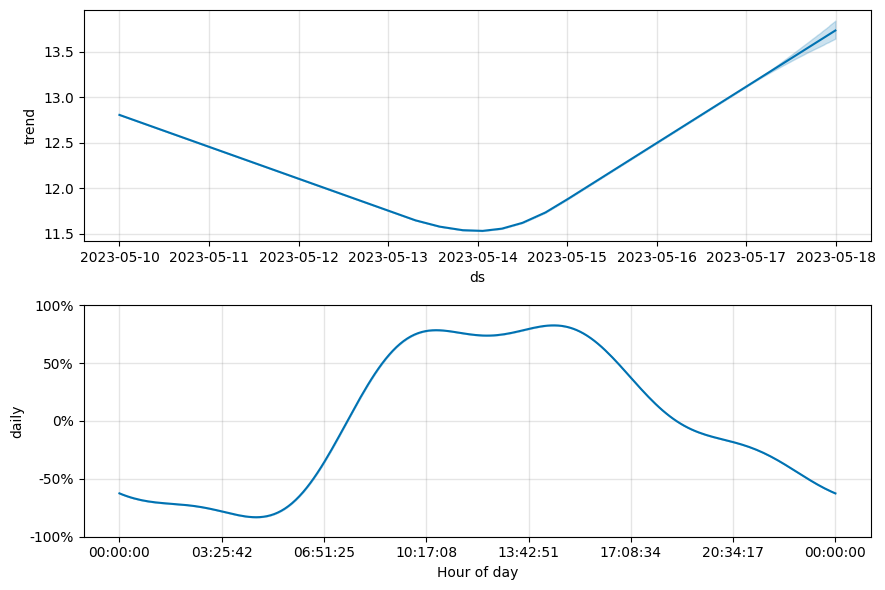

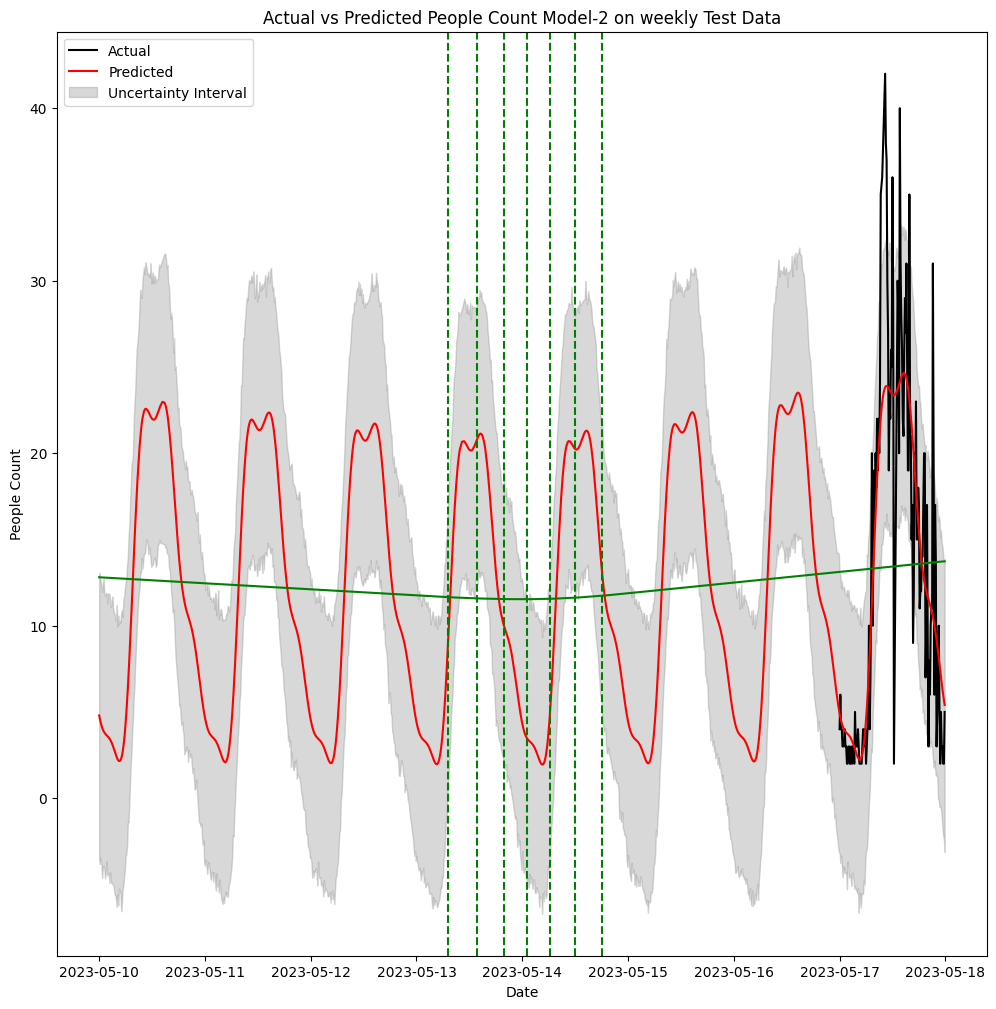

In [25]:
from prophet.plot import plot_components

# containing datetime values for the test period
df_test = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df_test['time'] = df_test['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)


# Choose the start date and end date for the one-week subset
test_start_date = '2023-05-17 00:00:00'
test_end_date = '2023-05-17 23:59:59'

start = datetime.strptime(test_start_date,'%Y-%m-%d %H:%M:%S')
end = datetime.strptime(test_end_date,'%Y-%m-%d %H:%M:%S')


# Filter the DataFrame to include only the data for the selected week
selected_test_data = df_test[(df_test['time'] >= test_start_date) & (df_test['time'] <= test_end_date)]

# Reset the index and drop the old index (unnamed column)
selected_test_data = selected_test_data.reset_index(drop=True).drop(columns=['Unnamed: 0'])


# print(selected_week_data)

# Resample the data to 10-minute intervals and forward-fill missing values

test_weather_data = fetch_weather_data(10675, start, end).set_index('time').resample('10T').ffill().reset_index()


#--------------------------------------------------------------------------------------------#



# Create the testing set

weekly_testing_set = pd.DataFrame({'ds': selected_test_data['time'], 
                                   'y': selected_test_data['people_count']})

#Working on dealing with outliers using Error standard deviation
# Initialize and fit the dummy Prophet model for 1 week to remove outliers beyond 95% uncertainity interval

dummy_weekly_testing_model = Prophet(seasonality_mode='multiplicative', 
                                     daily_seasonality=4, 
                                     seasonality_prior_scale=0.1, 
                                     changepoint_prior_scale=0.01, 
                                     interval_width=0.95)


dummy_weekly_testing_model.fit(weekly_testing_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_testing_model.predict()

#Filter the outliers
filtered_testing_set = weekly_testing_set[(weekly_testing_set['y'] > dummy_weekly_forecast['yhat_lower'].values) & (weekly_testing_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below 95% UI


# Create a future DataFrame for the test data
one_day_future_test = weekly_training_model.make_future_dataframe(periods=6*24, freq='10min')



# Make predictions on the test data
weekly_forecast_test = weekly_training_model.predict(one_day_future_test)

fig3 = plot_components(weekly_training_model,weekly_forecast_test)


# # Plot the actual vs predicted values for the test period
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(filtered_testing_set['ds'], filtered_testing_set['y'], label='Actual', color='black')
ax.plot(weekly_forecast_test['ds'], weekly_forecast_test['yhat'], label='Predicted', color='red')
ax.fill_between(weekly_forecast_test['ds'], weekly_forecast_test['yhat_lower'], weekly_forecast_test['yhat_upper'], color='grey', alpha=0.3, label='Uncertainty Interval')
ax.legend()
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count Model-2 on weekly Test Data')
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast_test,cp_linestyle='--',cp_color='green')
plt.show()

import plotly.graph_objects as go

# Create traces
actual_trace = go.Scatter(x=filtered_testing_set['ds'], y=filtered_testing_set['y'], mode='lines', name='Actual Count', line=dict(color='black'))
predicted_trace = go.Scatter(x=weekly_forecast_test['ds'], y=weekly_forecast_test['yhat'], mode='lines', name='Predicted Count', line=dict(color='red', width=4))
uncertainty_trace = go.Scatter(x=weekly_forecast_test['ds'], y=weekly_forecast_test['yhat_upper'], fill=None, mode='lines', line=dict(color='grey'), showlegend=False)
uncertainty_trace_filled = go.Scatter(x=weekly_forecast_test['ds'], y=weekly_forecast_test['yhat_lower'], fill='tonexty', mode='lines', line=dict(color='grey'), name='Uncertainty Interval')

# Define layout
layout = go.Layout(
    title=dict(text='Actual vs Predicted People Count Model-2 (with custom parameters and without regressor)', font=dict(color='black',size=25), x=0.5),
    xaxis=dict(
        title='Date',
        title_font=dict(color='black'),
        tickfont=dict(color='black')  # Set x-axis tick labels to black
    ),
    yaxis=dict(
        title='People Count',
        title_font=dict(color='black'),
        tickfont=dict(color='black')  # Set y-axis tick labels to black
    ),
    legend=dict(x=0.01, y=0.99, font=dict(color='black')),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Define lower and upper bounds for the x-axis
lower_bound = filtered_testing_set['ds'].min()
upper_bound = filtered_testing_set['ds'].max()

# Create figure and add traces
fig = go.Figure(data=[actual_trace, predicted_trace, uncertainty_trace, uncertainty_trace_filled], layout=layout)
fig.update_xaxes(range=[lower_bound, upper_bound], tickmode='auto', dtick='H1')

fig.show()

**Validation and Evaluation**

  0%|          | 0/2 [00:00<?, ?it/s]

21:36:45 - cmdstanpy - INFO - Chain [1] start processing
21:36:45 - cmdstanpy - INFO - Chain [1] done processing
21:36:45 - cmdstanpy - INFO - Chain [1] start processing
21:36:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon        mse      rmse      mae      mape     mdape     smape  \
0  1 days  38.183123  6.179249  4.16129  0.360234  0.293108  0.349841   

   coverage  
0  0.807143  


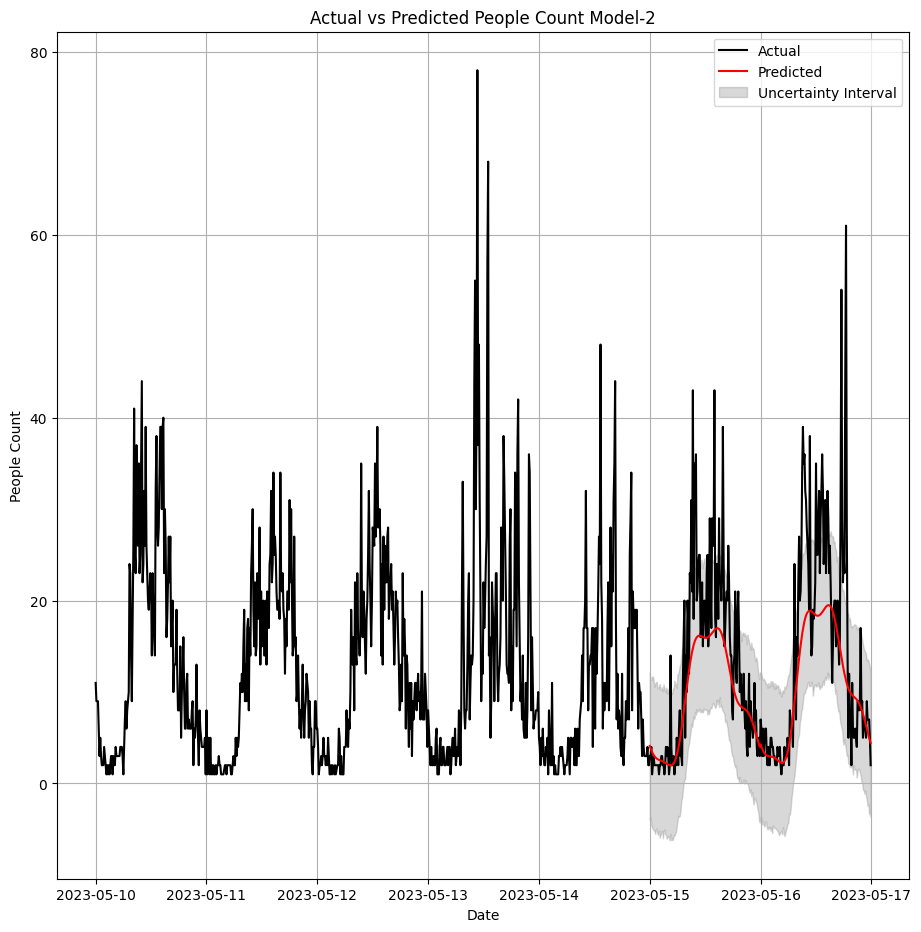

In [23]:

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics




default_model_cv = cross_validation(weekly_training_model, horizon= '1 days', period='1 days', initial='4 days')

# # Evaluate model performance
df_p = performance_metrics(default_model_cv,rolling_window=1)
print(df_p)

# Extract relevant columns from df
actual_data = training_set[['ds', 'y']]

# Extract relevant columns from df_cv
predicted_data = default_model_cv[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_data['ds'], actual_data['y'], label='Actual', color='black')  # Set actual data line color to black
plt.plot(predicted_data['ds'], predicted_data['yhat'], label='Predicted', color='red')  # Set predicted data line color to red
plt.fill_between(predicted_data['ds'], predicted_data['yhat_lower'], predicted_data['yhat_upper'], color='grey', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count')
plt.grid(visible='True')
plt.legend()
plt.show()
